In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# additional imports
import matplotlib.pyplot as plt
import gc
from dask import bag
from sklearn.preprocessing import MinMaxScaler
import ast
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
from datetime import datetime

# log transform function
def log_transform(values) :
    return np.log10(values + 1)

lr_patience = 2
market_sequence = 10
news_sequence = 1
train_num = 10
epoch_per_train = 1
batch_size = 1024
dropout = 0.2
l2_lambda = 0.001
learning_rate = 0.001
market_split_time = pd.tslib.Timestamp('2015-01-01 00:00:00')

use_news_data = True
if use_news_data :
    news_split_time = pd.tslib.Timestamp('2014-11-01 00:00:00')
else :
    news_split_time = pd.tslib.Timestamp('2020-11-01 00:00:00')

use_sample_weight = True
downgrade_universe_zero_sample = False
weight_decay_factor = 0.9
train_validate_ratio = 0.8
lr_decaying_factor = 0.9
minimum_lr = 0.0001
is_train = True

['marketdata_sample.csv', 'news_sample.csv']


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp


In [2]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

print("market data : ", market_train_df.shape)
print("news data : ", news_train_df.shape)

market_train_df['time'] = market_train_df['time'].dt.tz_localize(None)
news_train_df['time'] = news_train_df['time'].dt.tz_localize(None)

print("market data split time : ", market_split_time)
print("news data split time : ", news_split_time)
market_train_df = market_train_df[market_train_df['time']>=market_split_time]
news_train_df = news_train_df[news_train_df['time']>=news_split_time]

print("market data : ", market_train_df.shape)
print("news data : ", news_train_df.shape)

print("oldest time : ", market_train_df['time'].min())
print("latest time : ", market_train_df['time'].max())

market_train_df.sort_values(by=['assetCode', 'time'], inplace = True)
market_train_df.reset_index(drop = True, inplace = True)
news_train_df.reset_index(drop = True, inplace = True)

if market_train_df.shape[0] == 0 :
    market_train_df = None
if news_train_df.shape[0] == 0 :
    news_train_df = None
    
market_data = None
news_data = None

gc.collect()

Loading the data... This could take a minute.
Done!
market data :  (4072956, 16)
news data :  (9328750, 35)
market data split time :  2015-01-01 00:00:00
news data split time :  2014-11-01 00:00:00
market data :  (892200, 16)
news data :  (2211582, 35)
oldest time :  2015-01-02 22:00:00
latest time :  2016-12-30 22:00:00


0

In [3]:
# market data preprocessing stuff
market_feature_scaler = dict()
market_feature_clip = dict()
market_features = []

# assetCode indexing
code2idx = dict()
idx2code = dict()

#generate market data function
def generate_market_features(df) :
    
    df.sort_values(by=['assetCode', 'time'], inplace = True)
    df.reset_index(drop = True, inplace = True)

    for code in df['assetCode'].unique() :
        if code not in code2idx :
            code2idx[code] = len(code2idx)
            idx2code[len(idx2code)] = code    
            
    df['assetCode'] = df['assetCode'].apply(lambda x : code2idx[x]).astype(np.uint32)
    df['date'] = df['time'].apply(lambda x : x.strftime('%Y%m%d'))
    df['closeOpenDiffRatio'] = df['close'] / (df['open'] + 1e-4)
    
    drop_columns = [column for column in ['time', 'assetName', 'close', 'open', 'middle'] if column in df.columns]
    df.drop(drop_columns, axis = 1, inplace = True)
    gc.collect()
    
    market_features = [feature for feature in df.columns if feature not in ['date', 'assetCode', 'universe', 'returnsOpenNextMktres10']]

    for feature in market_features :
        df[feature].fillna(value = df[feature].quantile(0.5), inplace=True)
    
    # transform skrewed data
    non_log_features = [
        'middle_max_05', 'middle_max_10', 'middle_max_15', 'stochasticD_05', 'stochasticD_10', 'stochasticD_20'
    ]
    for feature in market_features :
        if feature not in non_log_features :
            df[feature] = log_transform(df[feature].values)
    
    for feature in market_features :
        df[feature].fillna(value = df[feature].quantile(0.5), inplace=True)
        
    for feature in market_features :
        if feature not in market_feature_clip :
            market_feature_clip[feature] = (df[df['universe']==1][feature].quantile(0.001), df[df['universe']==1][feature].quantile(0.999))
        df[feature] = df[feature].clip(market_feature_clip[feature][0], market_feature_clip[feature][1])

    for feature in market_features :
        if feature not in market_feature_scaler :
            market_feature_scaler[feature] = MinMaxScaler()
            df[feature] = market_feature_scaler[feature].fit_transform(df[feature].values.reshape(-1, 1)).reshape(-1)
        else :
            df[feature] = market_feature_scaler[feature].transform(df[feature].values.reshape(-1, 1)).reshape(-1)
    
    df[['date']] = df[['date']].astype(np.uint32)
    df[['universe']] = df[['universe']].astype(np.uint8)
    df[market_features] = df[market_features].astype('float32')
    
    return df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


(892200, 14)
volume


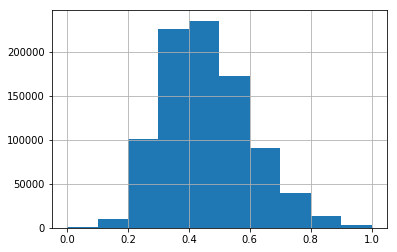

returnsClosePrevRaw1


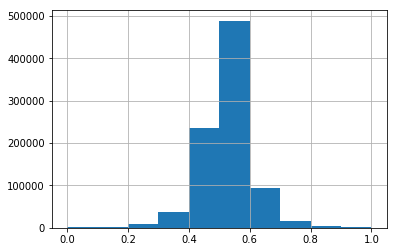

returnsOpenPrevRaw1


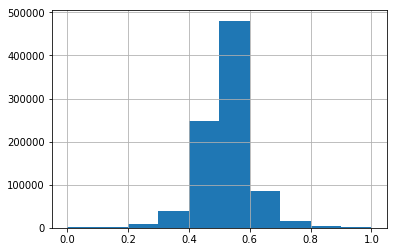

returnsClosePrevMktres1


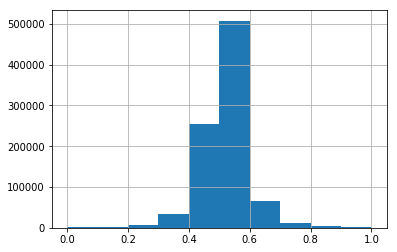

returnsOpenPrevMktres1


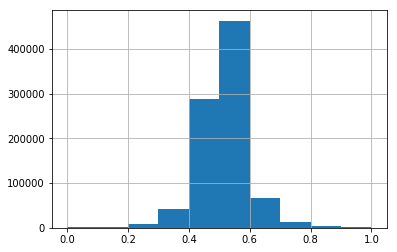

returnsClosePrevRaw10


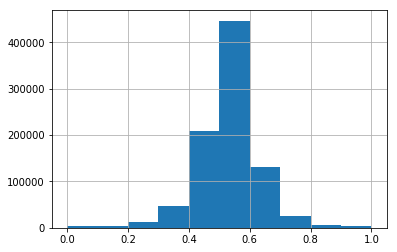

returnsOpenPrevRaw10


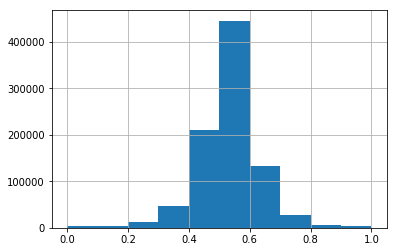

returnsClosePrevMktres10


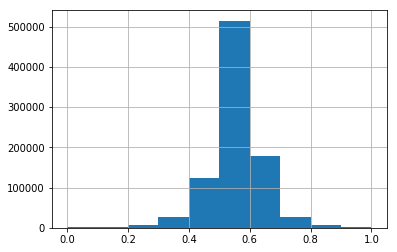

returnsOpenPrevMktres10


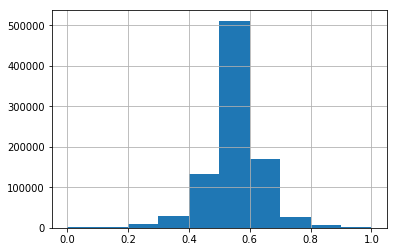

closeOpenDiffRatio


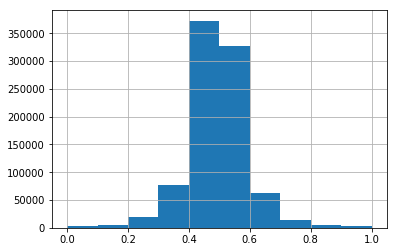

In [4]:
if market_train_df is not None :
    market_data = generate_market_features(market_train_df)
    print(market_data.shape)
    gc.collect()
    
    market_features = [feature for feature in market_data.columns if feature not in ['date', 'assetCode', 'universe', 'returnsOpenNextMktres10']]
    
    for feature in market_features :
        print(feature)
        market_data[feature].hist()
        plt.show()

    market_data.head()

In [5]:
# news data preprocessing stuff
news_feature_scaler = dict()
news_feature_clip = dict()
news_features = []

#generate news data
def generate_news_features(df) :

    df['date'] = df['time'].apply(lambda x : x.strftime('%Y%m%d'))
    df.loc[df['firstMentionSentence'] == 0, 'firstMentionSentence'] = df.loc[df['firstMentionSentence'] == 0, 'sentenceCount']
    drop_columns = [column for column in [
           'time', 'sourceTimestamp', 'firstCreated'
           ,'headline'
           ,'urgency'
           ,'takeSequence'
           ,'provider', 'subjects', 'audiences'
           ,'bodySize'
           ,'companyCount'
           ,'headlineTag', 'marketCommentary'
           ,'sentenceCount'
           ,'wordCount' 
           ,'firstMentionSentence'
           ,'relevance'
           ,'sentimentClass'
           #,'sentimentNegative', 'sentimentNeutral', 'sentimentPositive' 
           ,'sentimentWordCount'
           ,'noveltyCount12H'
           ,'noveltyCount24H','noveltyCount3D','noveltyCount5D','noveltyCount7D'
           ,'volumeCounts12H'
           ,'volumeCounts24H','volumeCounts3D','volumeCounts5D','volumeCounts7D'
    ] if column in df.columns]
    df.drop(drop_columns, axis = 1, inplace = True)
    gc.collect()
    
    # Factorize categorical columns
    for col in ['sourceId', 'assetName']:
        df[col], uniques = pd.factorize(df[col])
        del uniques
    
    df['assetCodes'] = df['assetCodes'].apply(lambda x : x[1:-1].replace("'", ''))
    df['assetCodes'] = df['assetCodes'].str.split(',')
    
    # build assetCode-news index for aggregating news data gorup by assetCode
    index = []
    for i, row in df.iterrows() :
        for c in row['assetCodes'] :
            code = c.strip()
            if code not in code2idx :
                code2idx[code] = len(code2idx)
                idx2code[len(idx2code)] = code
            index.append([code2idx[code], row['sourceId'], row['assetName']])
        if i % 100000 == 0 :
            print(i)
    index = pd.DataFrame(index)
    index.columns = ['assetCode', 'sourceId', 'assetName']
    df.drop(['assetCodes'], axis = 1, inplace = True)
    gc.collect()
    
    # aggregate news data 
    agg_dict = {
        'assetCode' : ['count']
        #, 'companyCount' : ['mean']
        #, 'sentenceCount' : ['mean']
        #, 'firstMentionSentence' : ['mean']
        #, 'urgency' : ['mean']
        #, 'relevance' : ['mean']
        #, 'sentimentNegative' : ['min', 'max', 'mean', 'std'], 'sentimentNeutral' : ['min', 'max', 'mean', 'std'], 'sentimentPositive' : ['min', 'max', 'mean', 'std'] 
        , 'sentimentNegative' : ['mean'], 'sentimentNeutral' : ['mean'], 'sentimentPositive' : ['mean'] 
        #, 'sentimentWordCount' : ['min', 'max', 'mean']
        #, 'wordCount' : ['min', 'max', 'mean']
        #, 'sentimentWordCount' : ['mean']
        #, 'wordCount' : ['mean']
        #, 'noveltyCount12H' : ['mean']
        #,'noveltyCount24H' : ['mean'],'noveltyCount3D' : ['mean']
        #, 'noveltyCount5D' : ['mean'],'noveltyCount7D' : ['mean']
        #, 'volumeCounts12H' : ['mean']
        #,'volumeCounts24H' : ['mean'],'volumeCounts3D' : ['mean']
        #, 'volumeCounts5D' : ['mean'],'volumeCounts7D' : ['mean']
    }

    df = index.merge(df, how='left', on=['sourceId', 'assetName']).drop(['assetName'], axis = 1).groupby(['date', 'assetCode']).agg(agg_dict)
    
    df.columns = pd.Index(["{}_{}".format(e[0], e[1]) for e in df.columns.tolist()])
    df.sort_values(by=['assetCode', 'date'], inplace=True)
    df.reset_index(inplace=True)
    del index
    gc.collect()
    
    news_features = [feature for feature in df.columns if feature not in ['date', 'assetCode', 'assetName']]
    
    log_transform_feature = [feature for feature in news_features if feature.split('_')[0] in [
        'sentimentWordCount', 'sentenceCount', 'wordCount', 'companyCount'
        ,'firstMentionSentence'
        ,'noveltyCount12H','noveltyCount24H','noveltyCount3D','noveltyCount5D','noveltyCount7D'
        ,'volumeCounts12H','volumeCounts24H','volumeCounts3D','volumeCounts5D','volumeCounts7D'
    ]]
    log_transform_feature.append('assetCode_count')
    
    for feature in news_features :
        df[feature].fillna(value = df[feature].quantile(0.5), inplace=True)
    
    for feature in log_transform_feature :
        df[feature] = log_transform(df[feature].values)
        
    for feature in news_features :
        df[feature].fillna(value = df[feature].quantile(0.5), inplace=True)
        
    for feature in news_features :
        if feature in df.columns :
            if feature not in news_feature_clip :
                news_feature_clip[feature] = (df[feature].quantile(0.01), df[feature].quantile(0.99))
            df[feature] = df[feature].clip(news_feature_clip[feature][0], news_feature_clip[feature][1])
    
    for feature in news_features :
        #if feature.split('_')[0] not in ['sentimentNegative', 'sentimentNeutral', 'sentimentPositive'] :
        if feature not in news_feature_scaler :
            news_feature_scaler[feature] = MinMaxScaler()
            df[feature] = news_feature_scaler[feature].fit_transform(df[feature].values.reshape(-1, 1)).reshape(-1)
        else :
            df[feature] = news_feature_scaler[feature].transform(df[feature].values.reshape(-1, 1)).reshape(-1)
    
    df[['assetCode']] = df[['assetCode']].astype(np.uint32)
    df[['date']] = df[['date']].astype(np.uint32)
    df[news_features] = df[news_features].astype('float32')
    
    return df

In [ ]:
if news_train_df is not None :
    news_data = generate_news_features(news_train_df)
    print(news_data.shape)
    gc.collect()

    news_features = [feature for feature in news_data.columns if feature not in ['date', 'assetCode', 'assetName']]
    
    for feature in news_features :
        print(feature)
        news_data[feature].hist()
        plt.show()

    news_data.head()

In [ ]:
# sequencial data generator
def generate_sequence_data(arr) :
    from_idx = 0
    assetCode = arr[-1, 0]
    for i in range(arr.shape[0] - 2, -1, -1) :
        if arr[i, 0] != assetCode :
            from_idx = i + 1
            break
    return np.array(arr[from_idx:, 1:], dtype = np.float32)

def generate_news_sequence_data(arr, date, idx, news_sequence, news_idx) :
    if idx == -1 :
        return np.asarray(np.zeros((1, len(arr[0, 2:]) + 1)), dtype = np.float32)
    idx_set = []
    code = arr[idx, 1]
    datetime_last = datetime(int(date / 10000), int((date % 10000)/100), int((date % 100)))
    date_diff = []
    for i in range(idx, arr.shape[0], 1) :
        if i + 1 < arr.shape[0] and (arr[i + 1, 1] == code and arr[i + 1, 0] <= date) :
            continue
        idx_set.append(i)
        news_idx[code] = i
        datetime_cur = datetime(int(arr[i, 0] / 10000), int((arr[i, 0] % 10000)/100), int((arr[i, 0] % 100)))  
        date_diff.append((datetime_last - datetime_cur).days)
        print(date, arr[i, 0], code, arr[i, 1])
        if len(idx_set) == news_sequence : 
            break
    if len(idx_set) == 0 :
        return np.asarray(np.zeros((1, len(arr[0, 2:]) + 1)), dtype = np.float32)
    date_diff = date_diff[::-1]
    date_diff.append(0)
    date_diff = [date_diff[0] + 1] + date_diff
    date_diff = np.array([-1 * diff for diff in date_diff], dtype = np.float32).reshape(-1, 1)
    date_diff = MinMaxScaler().fit_transform(date_diff)[1:-1]
    print(date_diff)
    result = np.asarray(arr[idx_set[-1]:idx_set[0]+1, 2:], dtype = np.float32)
    result = np.concatenate([result, date_diff], axis = 1)
    return result
        
# generate final data for train/prediction
def generate_model_data(df_market, df_news, split_date, market_sequence = 5, news_sequence = 1, is_predict = False) :

    df_market.sort_values(by=['assetCode', 'date'], inplace = True)
    df_market.reset_index(drop = True, inplace = True)
    
    if df_news is not None :
        df_news.sort_values(by=['assetCode', 'date'], inplace = True)
        df_news.reset_index(drop = True, inplace = True)
    
    train_idx = df_market[df_market['date'] < split_date].index.values.tolist()
    validate_idx = df_market[df_market['date'] >= split_date].index.values.tolist()
    
    dates = df_market['date'].values
    codes = df_market['assetCode'].values

    train_date = dates[train_idx].reshape(-1)
    validate_date = dates[validate_idx].reshape(-1)
    print("gen model data ", np.min(train_date), np.max(validate_date))

    train_code = codes[train_idx].reshape(-1)
    validate_code = codes[validate_idx].reshape(-1)

    train_news = None
    validate_news = None
    
    if df_news is not None :
        data = df_news.values
        if is_predict == False :
            df_news = df_news[df_news['date']>=20161001]
            gc.collect()   
        news_idx = dict()
        if is_predict == False : unique_codes = np.unique(np.concatenate([np.unique(train_code), np.unique(validate_code)]))
        else : unique_codes = np.unique(validate_code)
        for c in unique_codes :
            if c in news_idx : continue
            idx = np.where(data[:, 1] == c)[0]
            if len(idx) == 0 :
                news_idx[c] = -1
            else :
                news_idx[c] = idx[0]

        if is_predict == False : 
            train_news = np.asarray([generate_news_sequence_data(data, d, news_idx[c], news_sequence) for d, c in zip(train_date, train_code)])
            train_news = train_news.reshape(-1, len(news_features) + 1)
        validate_news = np.asarray([generate_news_sequence_data(data, d, news_idx[c], news_sequence) for d, c in zip(validate_date, validate_code)])
        validate_news = validate_news.reshape(-1, len(news_features) + 1)
        
        del news_idx
        del data
        gc.collect()
        
        #if is_predict == False : train_news = pad_sequences(train_news, maxlen = news_sequence, dtype = 'float32')
        #validate_news = pad_sequences(validate_news, maxlen = news_sequence, dtype = 'float32')
    
    returns = df_market['returnsOpenNextMktres10'].values
    universes = df_market['universe'].values
    labels = returns > 0.0
    
    train_y = labels[train_idx].reshape(-1)
    validate_y = labels[validate_idx].reshape(-1)
    
    train_return = returns[train_idx].reshape(-1)
    validate_return = returns[validate_idx].reshape(-1)
    
    train_universe = universes[train_idx].reshape(-1)
    validate_universe = universes[validate_idx].reshape(-1)
    
    data = df_market.drop(['universe', 'returnsOpenNextMktres10', 'date'], axis = 1).values
    if is_predict == False :
        df_market = df_market[df_market['date']>=20161101]
        gc.collect()
    
    train_x = None
    # generate sequencial data
    if is_predict == False : train_x = np.asarray([generate_sequence_data(data[max(0, i - market_sequence + 1) : i + 1]) for i in train_idx])
    validate_x = np.asarray([generate_sequence_data(data[max(0, i - market_sequence + 1) : i + 1]) for i in validate_idx])
    
    del train_idx
    del validate_idx
    del data
    gc.collect()
    
    # padding short sequence data
    if is_predict == False : train_x = pad_sequences(train_x, maxlen = market_sequence, dtype = 'float32')
    validate_x = pad_sequences(validate_x, maxlen = market_sequence, dtype = 'float32')
    
    train_data = {'x' : train_x, 'y' : train_y, 'd' : train_date, 'n' : train_news, 'r' : train_return, 'u' : train_universe, 'c' : train_code}
    validate_data = {'x' : validate_x, 'y' : validate_y, 'd' : validate_date, 'n' : validate_news, 'r' : validate_return, 'u' : validate_universe, 'c' : validate_code}

    return train_data, validate_data

In [ ]:
if market_data is not None : print("market data shape : ", market_data.shape)
if news_data is not None : print("news data shape : ", news_data.shape)

if is_train : validate_split_date = market_data['date'].unique()[int(market_data['date'].unique().shape[0] * train_validate_ratio)]
else : validate_split_date = market_data['date'].unique()[-1]
print("validation data split date : ", validate_split_date)

news_sequence = 1
train_data, validate_data = generate_model_data(market_data, news_data, validate_split_date, market_sequence, news_sequence)

# remaining only recent data for future prediction
if market_data is not None : market_data = market_data[market_data['date'] >= 20161101]
if news_data is not None : news_data = news_data[news_data['date'] >= 20161101]

gc.collect()

In [ ]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

from keras.models import Model, Sequential
from keras.layers import Dense, Input, LSTM, Bidirectional, Dropout, BatchNormalization, Flatten, concatenate, Activation, Embedding, CuDNNLSTM, GRU, CuDNNGRU, Embedding
from keras.layers import Reshape, TimeDistributed, GRUCell, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import regularizers

inp_news = Input(shape=(len(news_features) + 1, ))

inp_market = Input(shape=(market_sequence, len(market_features)))
x = BatchNormalization()(inp_market)
x = Bidirectional(GRU(128
          , kernel_regularizer = regularizers.l2(l2_lambda)
          , bias_regularizer   = regularizers.l2(l2_lambda)
          , return_sequences   = True
          , recurrent_dropout  = dropout
                      ))(x)
x = BatchNormalization()(x)
x = Attention(market_sequence)(x)

if use_news_data :
    x = concatenate([x, inp_news])
    x = BatchNormalization()(x)
    
x = Dense(1, activation='sigmoid'
          #, kernel_regularizer = regularizers.l2(l2_lambda)
          #, bias_regularizer   = regularizers.l2(l2_lambda)
         )(x)

if use_news_data :
    model = Model(inputs=[inp_market, inp_news], outputs=x)
else :
    model = Model(inputs=[inp_market], outputs=x)

adam = Adam(lr=learning_rate)

# set callbacks
best_model_file = "best_model.chk"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = lr_decaying_factor, patience = lr_patience, min_lr = minimum_lr)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', restore_best_weights=True)

callbacks_list = [checkpoint, reduce_lr, early_stop]
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# training metrics history
two_sigma_score = []
val_loss = []
val_acc = []

gc.collect()

In [ ]:
# adjust loss weight for each sample based on the degree of its return rate 
def cal_batch_weight(values, u) :
    if use_sample_weight == False :
        return np.ones(values.shape)
    u_mask = u == 0
    weight = np.asarray(values)
    weight = np.clip(weight, -0.99, 0.99)
    weight = (np.abs(weight)**2)
    weight += 1.0
    if downgrade_universe_zero_sample :
        weight[u_mask] *= weight_decay_factor # downgrade weight of data with universe = 0
    return weight

train_input = [train_data['x']]
validate_input = [validate_data['x']]
if use_news_data :
    train_input.append(train_data['n'])
    validate_input.append(validate_data['n'])

for e in range(train_num) :
    print("train num : ", e + 1) 
        
    history = model.fit(train_input, train_data['y'], batch_size = batch_size, epochs = epoch_per_train
              , validation_data = (validate_input, validate_data['y'], cal_batch_weight(validate_data['r'], validate_data['u']))
              , sample_weight = cal_batch_weight(train_data['r'], train_data['u'])
              , callbacks = callbacks_list)
    
    predict = model.predict(validate_input)
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_acc'])
    confidence_valid = predict.reshape(-1) * 2 - 1
    x_t_i = confidence_valid * validate_data['r'] * validate_data['u']
    data = {'day' : validate_data['d'], 'x_t_i' : x_t_i}
    df = pd.DataFrame(data)
    x_t = df.groupby('day').sum().values.flatten()
    mean = np.mean(x_t)
    std = np.std(x_t)
    score_valid = mean / std
    print("two sigma score : ", score_valid)
    two_sigma_score.append(score_valid)       
    
gc.collect()

In [ ]:
del two_sigma_score
del val_loss
del val_acc
del train_data
del validate_data
gc.collect()

In [ ]:
# predict future data
days = env.get_prediction_days()

for (market_obs_df, news_obs_df, predictions_template_df) in days:
    
    market_obs_df['returnsOpenNextMktres10'] = 0.0
    market_obs_df['universe'] = 0
    market_obs_df['time'] = market_obs_df['time'].dt.tz_localize(None)
    market_data = market_data.append(generate_market_features(market_obs_df))

    market_data.sort_values(by=['assetCode', 'date'], inplace = True)
    prediction_start_date = market_data['date'].max()
    
    if use_news_data :
        news_data = news_data.append(generate_news_features(news_obs_df))
    else :
        news_data = None

    _, test_data = generate_model_data(market_data, news_data, prediction_start_date, market_sequence, news_sequence, is_predict = True)
    
    # make prediction
    test_input = [test_data['x']]
    if use_news_data :
        test_input.append(test_data['n'])
    predict = model.predict(test_input)
    
    # make result
    result = pd.DataFrame()
    result['assetCode'] = test_data['c']
    result['assetCode'] = result['assetCode'].apply(lambda x : idx2code[x])
    result['confidenceValue'] = predict.reshape(-1) * 2 - 1
    
    del test_data
    
    predictions_template_df.drop(['confidenceValue'], axis = 1, inplace = True)
    predictions_template_df = predictions_template_df.merge(result, how='left', on='assetCode')
    env.predict(predictions_template_df)
    
    # maintaining only recent data
    market_first_date = market_data['date'].min()
    market_data = market_data[market_data['date'] > market_first_date]
    if use_news_data :
        news_first_date = news_data['date'].min()
        news_data = news_data[news_data['date'] > news_first_date]
    gc.collect()
    
env.write_submission_file()